In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
import splitfolders # or import splitfolders
input_folder = "AutismDataset/consolidated"
output = "AutismDataset/output" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .3)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 2940 files [00:03, 934.34 files/s] 


In [3]:
train_path = "AutismDataset/output/train"
test_path = "AutismDataset/output/val"

In [4]:
IMAGE_SIZE = [128,128]

In [5]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 2058 images belonging to 2 classes.
Found 882 images belonging to 2 classes.


In [7]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

# GoogleNet

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import concatenate

In [9]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer


In [10]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (128, 128, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(2, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X], name = 'GoogLeNet')

  return model


In [11]:
model1 = GoogLeNet()
model1.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 61, 61, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 30, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 64)   4160        max_pooling2d[0][0]              
__________________________________________________________________________________________

In [12]:
model1.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [13]:
hist1 = model1.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
1029/1029 [==============================] - 142s 134ms/step - loss: 0.6969 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
1029/1029 [==============================] - 127s 124ms/step - loss: 0.6935 - accuracy: 0.5078 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/20
1029/1029 [==============================] - 129s 126ms/step - loss: 0.6939 - accuracy: 0.5005 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/20
1029/1029 [==============================] - 130s 127ms/step - loss: 0.6939 - accuracy: 0.4942 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/20
1029/1029 [==============================] - 130s 127ms/step - loss: 0.6933 - accuracy: 0.4883 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/20
1029/1029 [==============================] - 132s 128ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
1029/1029 [=========

In [14]:
model1.save('google.h5')

In [28]:
val1 = hist1.history['val_accuracy'][10]

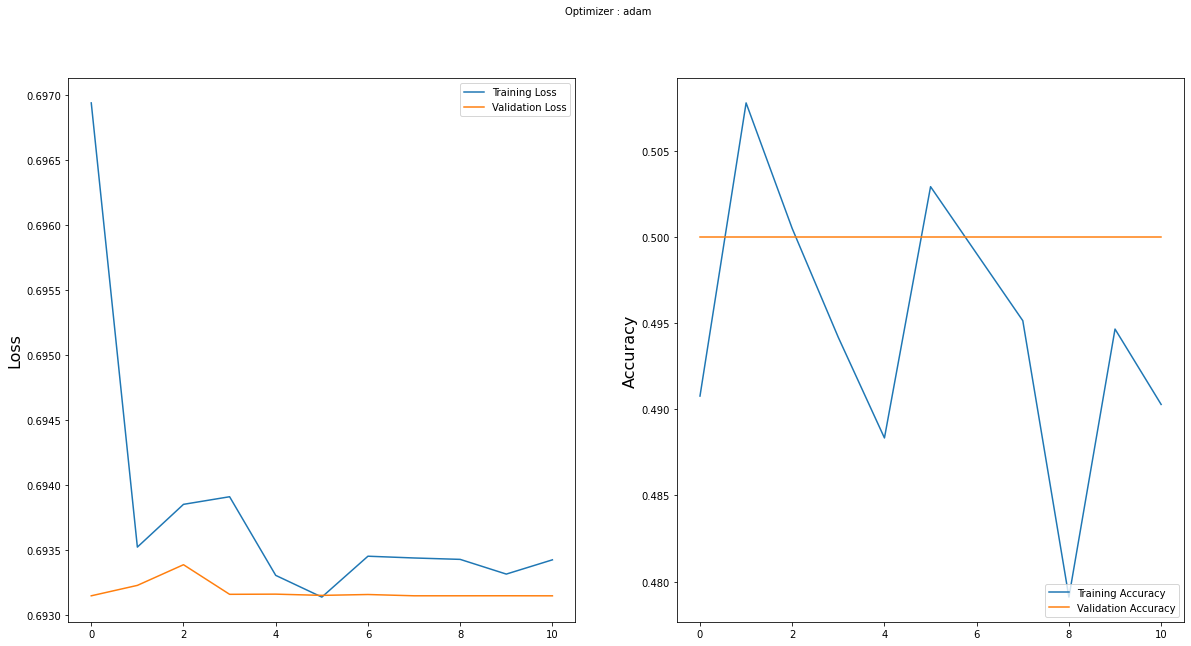

In [15]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# InceptionV3

In [16]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base_model = InceptionV3(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x2 = base_model.output
x2 = GlobalAveragePooling2D()(x2)

In [17]:
predictions = Dense(2, activation='softmax')(x2)

# this is the model we will train
model2 = Model(inputs=base_model.input, outputs=predictions)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
model2.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [19]:
hist2 = model2.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
1029/1029 [==============================] - 300s 281ms/step - loss: 0.8799 - accuracy: 0.5165 - val_loss: 44.1343 - val_accuracy: 0.5646
Epoch 2/20
1029/1029 [==============================] - 284s 276ms/step - loss: 0.7756 - accuracy: 0.5063 - val_loss: 121.3189 - val_accuracy: 0.4887
Epoch 3/20
1029/1029 [==============================] - 283s 275ms/step - loss: 0.7447 - accuracy: 0.4966 - val_loss: 537.1797 - val_accuracy: 0.5193
Epoch 4/20
1029/1029 [==============================] - 281s 273ms/step - loss: 0.7403 - accuracy: 0.5141 - val_loss: 355.0284 - val_accuracy: 0.5159

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/20
1029/1029 [==============================] - 281s 273ms/step - loss: 0.7065 - accuracy: 0.4869 - val_loss: 38.7670 - val_accuracy: 0.5238
Epoch 6/20
1029/1029 [==============================] - 287s 279ms/step - loss: 0.7062 - accuracy: 0.4937 - val_loss: 466.8442 - val_accuracy: 0.6134
Epoch 7/20
1029/1029 

In [29]:
val2 = hist2.history['val_accuracy'][15]

In [20]:
model2.save('incep.h5')

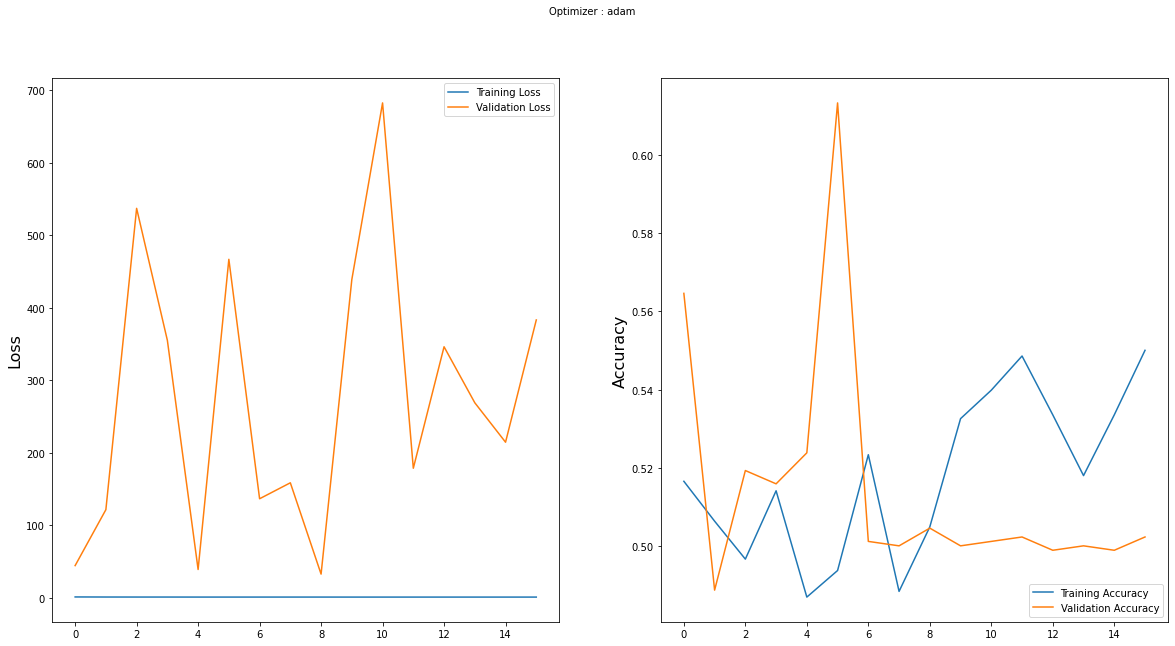

In [21]:
import matplotlib.pyplot as plt

x=hist2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# ResNet

In [22]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [23]:
x = Flatten()(resnet.output)
prediction = Dense(2, activation='softmax')(x)
model3 = Model(inputs = resnet.inputs, outputs = prediction)
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [24]:
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [26]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
1029/1029 [==============================] - 512s 488ms/step - loss: 2.0046 - accuracy: 0.5068 - val_loss: 2.0833 - val_accuracy: 0.4955
Epoch 2/20
1029/1029 [==============================] - 495s 481ms/step - loss: 1.6105 - accuracy: 0.5087 - val_loss: 13.6877 - val_accuracy: 0.4898
Epoch 3/20
1029/1029 [==============================] - 491s 477ms/step - loss: 0.8916 - accuracy: 0.5588 - val_loss: 25.5619 - val_accuracy: 0.6315
Epoch 4/20
1029/1029 [==============================] - 487s 473ms/step - loss: 0.8073 - accuracy: 0.5622 - val_loss: 1.1225 - val_accuracy: 0.5624
Epoch 5/20
1029/1029 [==============================] - 490s 476ms/step - loss: 0.7732 - accuracy: 0.5481 - val_loss: 0.8087 - val_accuracy: 0.5567
Epoch 6/20
1029/1029 [==============================] - 499s 485ms/step - loss: 0.7744 - accuracy: 0.5617 - val_loss: 16.7678 - val_accuracy: 0.5045

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/20
1029/1029 [======

In [30]:
val3 = hist3.history['val_accuracy'][19]

In [ ]:
model3.save('resnet.h5')

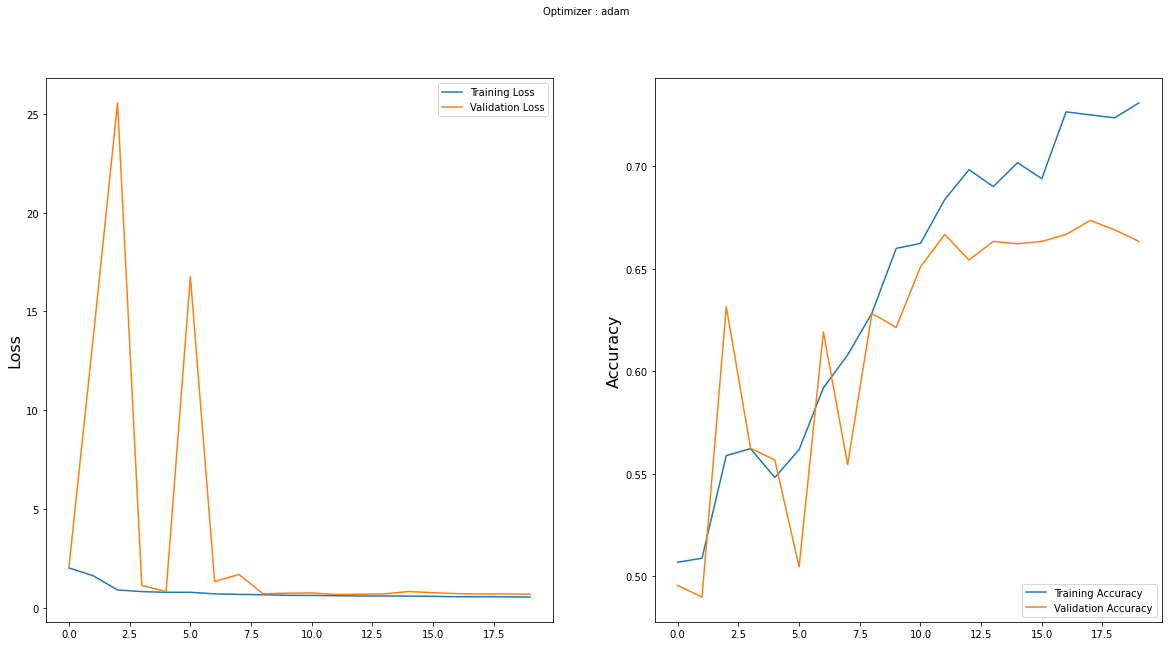

In [27]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet

In [28]:
from tensorflow.keras.applications import DenseNet201

In [29]:
des201=DenseNet201(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [30]:
x1= Flatten()(des201.output)
prediction1 = Dense(2, activation='softmax')(x1)
model7 = Model(inputs = des201.inputs, outputs = prediction1)
model7.summary()
model7.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Total params: 18,383,426
Trainable params: 18,154,370
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [31]:
hist7 = model7.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
1029/1029 [==============================] - 995s 942ms/step - loss: 2.9802 - accuracy: 0.5170 - val_loss: 1.3680 - val_accuracy: 0.6156
Epoch 2/20
1029/1029 [==============================] - 962s 935ms/step - loss: 1.2060 - accuracy: 0.5705 - val_loss: 5.3094 - val_accuracy: 0.4921
Epoch 3/20
1029/1029 [==============================] - 813s 790ms/step - loss: 0.8200 - accuracy: 0.6093 - val_loss: 5.3368 - val_accuracy: 0.6190
Epoch 4/20
1029/1029 [==============================] - 753s 731ms/step - loss: 0.6412 - accuracy: 0.6657 - val_loss: 0.8127 - val_accuracy: 0.6315
Epoch 5/20
1029/1029 [==============================] - 752s 731ms/step - loss: 0.6635 - accuracy: 0.6273 - val_loss: 2.2125 - val_accuracy: 0.7132
Epoch 6/20
1029/1029 [==============================] - 751s 730ms/step - loss: 0.6183 - accuracy: 0.6642 - val_loss: 1.7283 - val_accuracy: 0.6984
Epoch 7/20
1029/1029 [==============================] - 750s 729ms/step - loss: 0.5865 - accuracy: 0.6880 - val_

In [31]:
val4 = hist7.history['val_accuracy'][19]

In [32]:
model7.save('dense.h5')

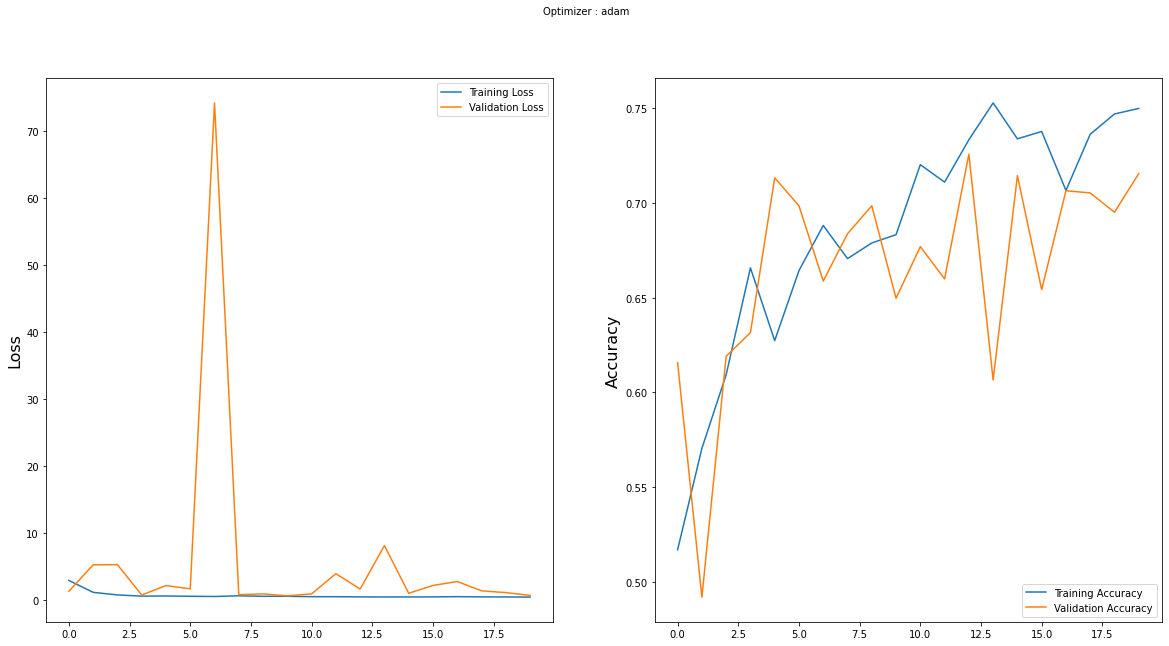

In [33]:
import matplotlib.pyplot as plt

x=hist7
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [9]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(2, activation='softmax')(x)
# Combining base and head 
model8 = Model(inputs=base.input, outputs=head)

In [10]:
model8.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy"])

In [11]:
model8.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [13]:
hist8 = model8.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
441/441 [==============================] - 261s 592ms/step - loss: 0.0610 - accuracy: 0.9751 - val_loss: 0.0810 - val_accuracy: 0.9796
Epoch 2/20
441/441 [==============================] - 248s 563ms/step - loss: 0.0479 - accuracy: 0.9875 - val_loss: 0.0632 - val_accuracy: 0.9819
Epoch 3/20
441/441 [==============================] - 249s 564ms/step - loss: 0.0307 - accuracy: 0.9898 - val_loss: 0.0701 - val_accuracy: 0.9841
Epoch 4/20
441/441 [==============================] - 247s 559ms/step - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.0395 - val_accuracy: 0.9909
Epoch 5/20
441/441 [==============================] - 247s 561ms/step - loss: 0.0129 - accuracy: 0.9989 - val_loss: 0.0412 - val_accuracy: 0.9932
Epoch 6/20
441/441 [==============================] - 248s 562ms/step - loss: 0.0130 - accuracy: 0.9977 - val_loss: 0.0280 - val_accuracy: 0.9943
Epoch 7/20
441/441 [==============================] - 246s 558ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0353 -

In [33]:
val5 = hist8.history['val_accuracy'][19]

In [14]:
model8.save('xcept.h5')

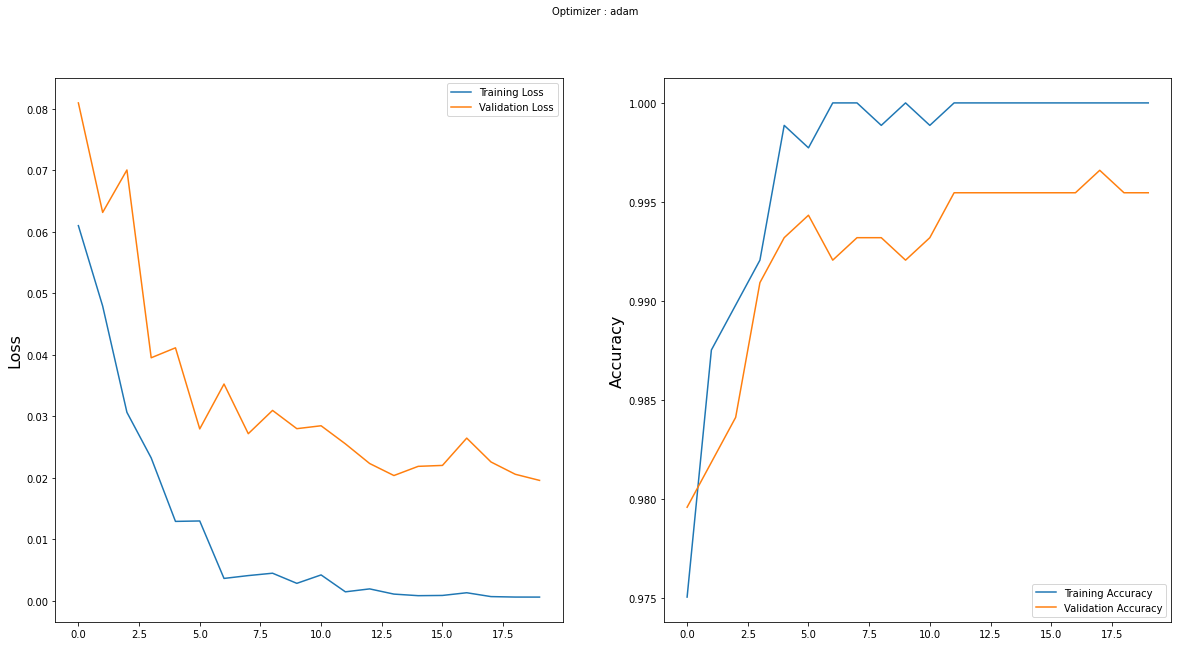

In [15]:
import matplotlib.pyplot as plt

x=hist8
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# MobileNet

In [16]:
from tensorflow.keras.applications import MobileNetV2

mob1 = MobileNetV2(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [17]:
x1= Flatten()(mob1.output)
prediction1 = Dense(2, activation='softmax')(x1)
model9 = Model(inputs = mob1.inputs, outputs = prediction1)
model9.summary()
model9.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [18]:
hist9 = model9.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
1029/1029 [==============================] - 170s 162ms/step - loss: 2.0785 - accuracy: 0.5637 - val_loss: 26.7365 - val_accuracy: 0.4989
Epoch 2/20
1029/1029 [==============================] - 149s 145ms/step - loss: 0.9251 - accuracy: 0.6608 - val_loss: 23.8484 - val_accuracy: 0.5000
Epoch 3/20
1029/1029 [==============================] - 146s 142ms/step - loss: 2.0555 - accuracy: 0.5515 - val_loss: 5.2568 - val_accuracy: 0.4921
Epoch 4/20
1029/1029 [==============================] - 145s 141ms/step - loss: 1.0444 - accuracy: 0.5569 - val_loss: 9.7161 - val_accuracy: 0.5181
Epoch 5/20
1029/1029 [==============================] - 147s 143ms/step - loss: 0.8891 - accuracy: 0.5889 - val_loss: 1.1940 - val_accuracy: 0.6100
Epoch 6/20
1029/1029 [==============================] - 147s 143ms/step - loss: 0.8513 - accuracy: 0.5719 - val_loss: 9.2085 - val_accuracy: 0.5011
Epoch 7/20
1029/1029 [==============================] - 147s 143ms/step - loss: 0.9061 - accuracy: 0.5675 - va

In [34]:
val6 = hist9.history['val_accuracy'][19]

In [19]:
model9.save('mobile.h5')

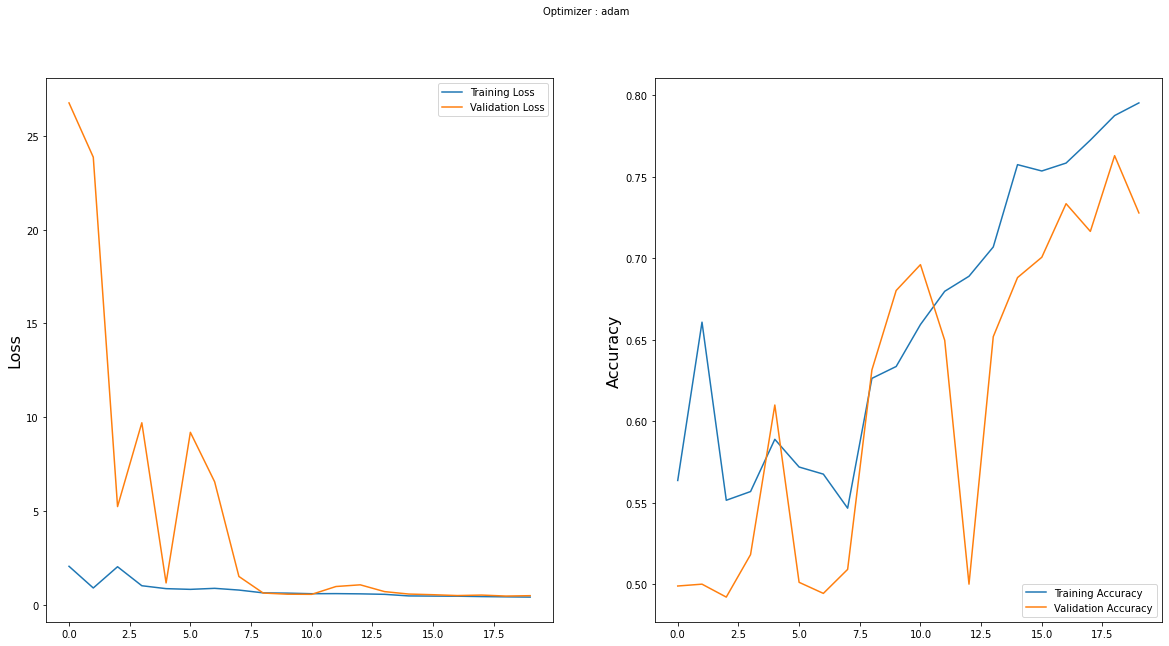

In [20]:
import matplotlib.pyplot as plt

x=hist9
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Hybrid Model

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
import efficientnet.keras 
def ensemble():

    model_1 = load_model('dense.h5', compile=False)
    model_1 = Model(inputs = model_1.inputs, outputs = model_1.outputs, name = 'DenseNet')

    model_2 = load_model('xcept.h5', compile=False)
    model_2 = Model(inputs = model_2.inputs, outputs = model_2.outputs, name = 'Xception')


    models = [model_1, model_2]


    models_input = Input(shape =(128,128,3))
    models_output = [model(models_input) for model in models]
    
    ensemble_output = Average()(models_output)

    simple_average = Model(inputs = models_input, outputs = ensemble_output, name = 'Ensemble')

    return simple_average

In [22]:
model = ensemble()
model.summary()

Model: "Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
DenseNet (Functional)           (None, 2)            18383426    input_3[0][0]                    
__________________________________________________________________________________________________
Xception (Functional)           (None, 2)            20865578    input_3[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 2)            0           DenseNet[0][0]                   
                                                                 Xception[0][0]            

In [24]:
model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [25]:
hist = model.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
1029/1029 [==============================] - 1180s 1s/step - loss: 0.5878 - accuracy: 0.6351 - val_loss: 0.9330 - val_accuracy: 0.5522
Epoch 2/20
1029/1029 [==============================] - 1305s 1s/step - loss: 0.5812 - accuracy: 0.6346 - val_loss: 0.5652 - val_accuracy: 0.6939
Epoch 3/20
1029/1029 [==============================] - 1246s 1s/step - loss: 0.6000 - accuracy: 0.6059 - val_loss: 0.6961 - val_accuracy: 0.5023
Epoch 4/20
1029/1029 [==============================] - 1254s 1s/step - loss: 0.7346 - accuracy: 0.5413 - val_loss: 0.7007 - val_accuracy: 0.4932
Epoch 5/20
1029/1029 [==============================] - 1254s 1s/step - loss: 0.7871 - accuracy: 0.5345 - val_loss: 0.8679 - val_accuracy: 0.5782

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/20
1029/1029 [==============================] - 1265s 1s/step - loss: 0.6862 - accuracy: 0.5641 - val_loss: 1.1997 - val_accuracy: 0.6406
Epoch 7/20
1029/1029 [=====================

In [35]:
val7 = hist.history['val_accuracy'][11]

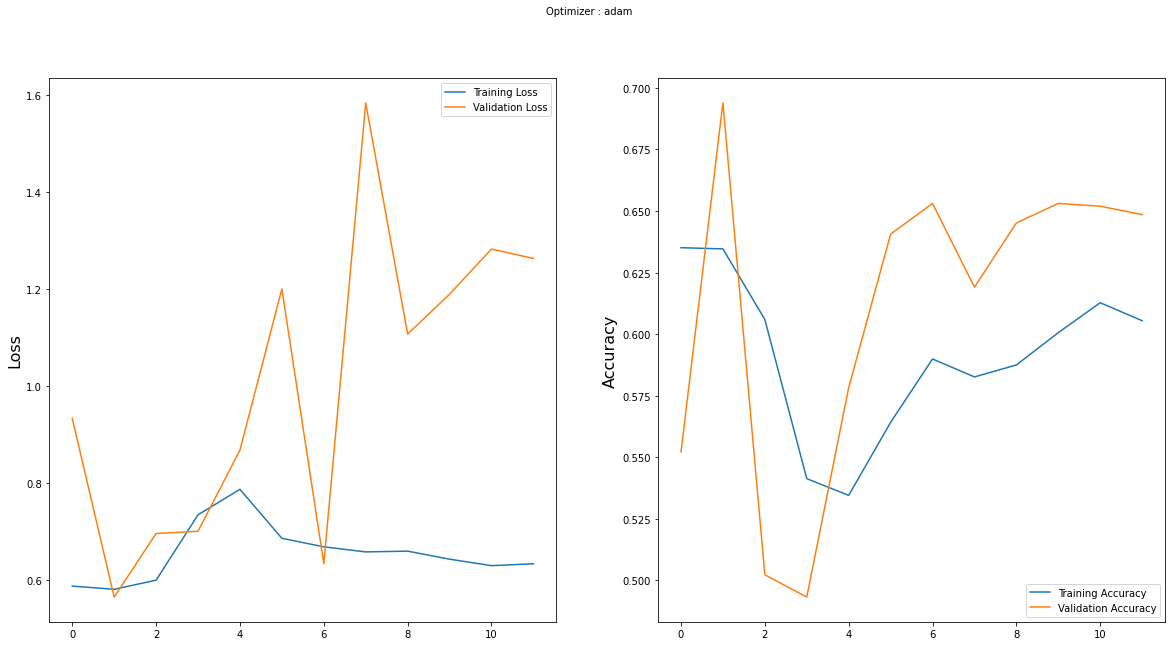

In [26]:
import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [36]:
x=['GoogleNet','InceptionV3','ResNet','DenseNet','Xception','MobileNet','DenseNet+Xception']

In [38]:
y = [val1,val2,val3,val4,val5,val6,val7]

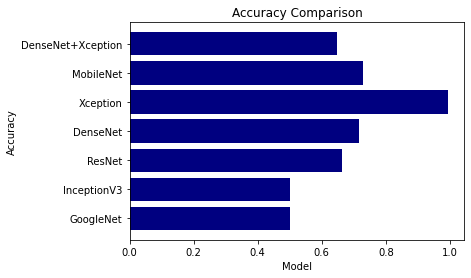

In [44]:
plt.barh(x,y, color='navy')
plt.xlabel('Model')
plt.ylabel("Accuracy")
plt.title('Accuracy Comparison')
plt.show()